In [25]:
import os
import time
import collections
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import medfilt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import normalize
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_recall_fscore_support

In [2]:
### READING DATASET ###

# Paths
dataset_path = 'Dataset'
games_dir = next(os.walk(dataset_path))[1]

tag_to_skip = [
    'highlights', 'highlights2', '.DS_Store', '.git', 
    'em_mcs_energy_diff_ascending', 'em_mcs_energy_diff', 'em_mcs_energy']

# Iterating through games
games_data = []
games_path = [os.path.join(dataset_path, g) for g in games_dir]
for path in games_path:
    game_name = os.path.basename(path)
    game_info = os.listdir(path)
    data = collections.OrderedDict()
    for info in game_info:
        tag_name = os.path.splitext(info)[0]
        if tag_name not in tag_to_skip:
            csv_file = os.path.join(path, info)
            if tag_name == 'highlights_boundaries':
                data_value = np.genfromtxt(csv_file, delimiter=',', dtype=None)
            else:
                data_value = np.fromfile(csv_file, sep=' ')
            data[tag_name] = data_value
    data['name'] = game_name
    games_data.append(data)

games_backup = games_data[:]


### CRIANDO VETOR DE GT ###

wanted_cases = ['Gol', 'Perigo']
to_skip = ['name', 'highlights_boundaries']

for game in games_data:
    h = game['highlights_boundaries']
    end = h[-1][0]
    gt = np.zeros(end)
    for line in h:
        tag = line[2].decode('UTF-8').split(' ')
        name = [t for t in tag if t != ''][-1]
        if name in wanted_cases:
            gt[line[0]-1:line[1]] = 1                   
            
    game['gt'] = gt
    del game['highlights_boundaries']
    
### CORTANDO VALORES EXCEDENTES PARA QUE TODOS OS DADOS TENHAM O MESMO TAMANHO ###

for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    min_l = min(values)
    for k, v in game.items():
        if len(v) > min_l:
            game[k] = v[:min_l]
            

### ZERO PADDING ###
max_length = 0
for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    max_length = max(values) if max(values)>max_length else max_length

for game in games_data:
    for k, v in game.items():
        if k not in ['name']:
            zero_v = np.zeros(max_length)
            if len(v) < max_length:
                zero_v[:len(v)] = v
                game[k] = zero_v

C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.


In [13]:
def get_frames_ids(gt):
    u, counts = np.unique(gt, return_counts=True)
    ind_0 = [i for i, v in enumerate(gt) if v == 0.0]
    ind_1 = [i for i, v in enumerate(gt) if v == 1.0]
    
    ind_0_ids = np.linspace(0, counts[0]-1, counts[1], dtype=int)
    new_ind_0 = [ind_0[j] for j in ind_0_ids]
    
    return sorted(new_ind_0 + ind_1)



def get_matrix(restriction, norm=True):
    data = []
    gt = []
    for game in games_data:
        if game['name'] in restriction:
            values_array = np.array(list(game.values()))

            # Getting GT
            gt_game = list(values_array[gt_id])

            # Removing name and GT to train
            values_array = np.delete(values_array, (max(name_id, gt_id)), axis=0)
            values_array = np.delete(values_array, (min(name_id, gt_id)), axis=0)    

            frames_ids = get_frames_ids(gt_game)
            gt += [gt_game[i] for i in frames_ids]

            game_features = []
            for feature in values_array:
                    
                if norm:
                    # Normalizing
                    M_feature = np.squeeze(normalize([feature], axis=1))
                else:
                    M_feature = feature
                    
                M_feature = M_feature[frames_ids]

                M_feature = np.transpose([M_feature])
                if len(game_features) == 0:
                    game_features = M_feature
                else:
                    game_features = np.concatenate((game_features, M_feature), axis=1)

            if len(data) == 0:
                data = game_features
            else:
                data = np.concatenate((data, game_features), axis=0)

    gt = np.array(gt)
    
    return data, gt

In [14]:
### DIVIDING SPLITS FROM TRAIN, TEST ###

games_test = ['chi_swi', 'san_vas']
games_train = [g['name'] for g in games_data if g['name'] not in games_test]

print('Total train: {}'.format(len(games_train)))
print('Total test: {}'.format(len(games_test)))

Total train: 28
Total test: 2


In [15]:
# SEM NORMALIZACAO

for i, tag_name in enumerate(games_data[10].keys()):
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i

X_train, y_train = get_matrix(games_train, norm=False)

X_test, y_test = get_matrix(games_test, norm=False)


print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (162472, 16) (162472,)
Test (9284, 16) (9284,)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)
Average precision-recall score: 0.79
Precision: [0.7735369 0.8979376]
Recall: [0.91684619 0.73158121]
[[4256  386]
 [1246 3396]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Average precision-recall score: 0.81
Precision: [0.79302023 0.90505517]
Recall: [0.92029298 0.75980181]
[[4272  370]
 [1115 3527]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   37.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Average precision-recall score: 0.81
Precision: [0.80033777 0.90467762]
Recall: [0.91878501 0.77078845]
[[4265  377]
 [1064 3578]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   54.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


Average precision-recall score: 0.82
Precision: [0.80356808 0.90831018]
Recall: [0.92180095 0.77466609]
[[4279  363]
 [1046 3596]]

--------------------------------------------------------------


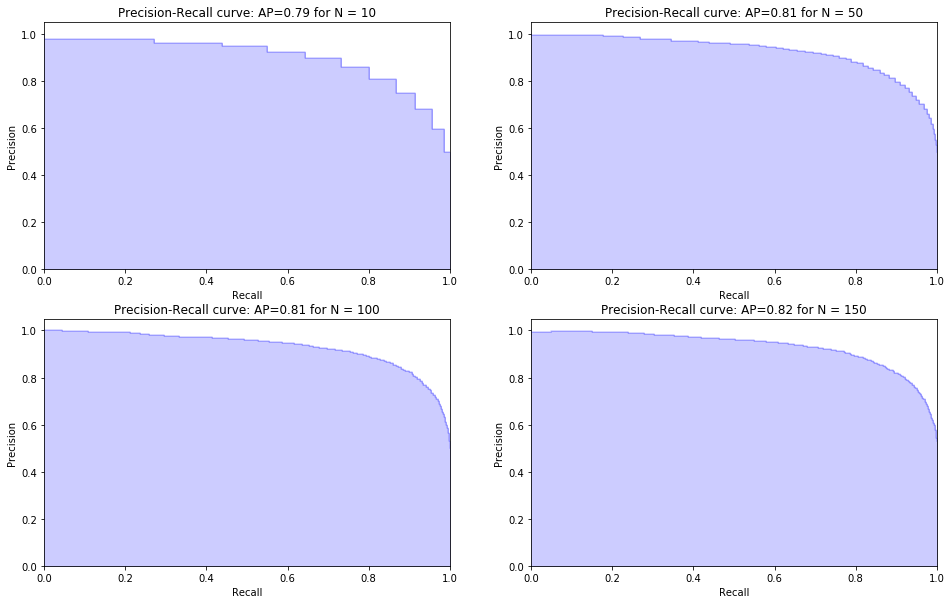

In [17]:
# SEM NORMALIZACAO

estimators = [10, 50, 100, 150]
models_norm = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models_norm.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for N = {}'.format(average_precision, n_est))
    print('\n--------------------------------------------------------------')
plt.show()

In [19]:
# COM NORMALIZACAO

for i, tag_name in enumerate(games_data[10].keys()):
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i

X_train, y_train = get_matrix(games_train)

X_test, y_test = get_matrix(games_test)


print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (162472, 16) (162472,)
Test (9284, 16) (9284,)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


Average precision-recall score: 0.78
Precision: [0.75708935 0.89203155]
Recall: [0.91447652 0.70659199]
[[4245  397]
 [1362 3280]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


Average precision-recall score: 0.80
Precision: [0.78872194 0.89982019]
Recall: [0.91598449 0.75463162]
[[4252  390]
 [1139 3503]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   31.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Average precision-recall score: 0.80
Precision: [0.79003359 0.89582272]
Recall: [0.91189143 0.75764757]
[[4233  409]
 [1125 3517]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   47.9s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


Average precision-recall score: 0.80
Precision: [0.79190751 0.89926039]
Recall: [0.91490737 0.75958639]
[[4247  395]
 [1116 3526]]

--------------------------------------------------------------


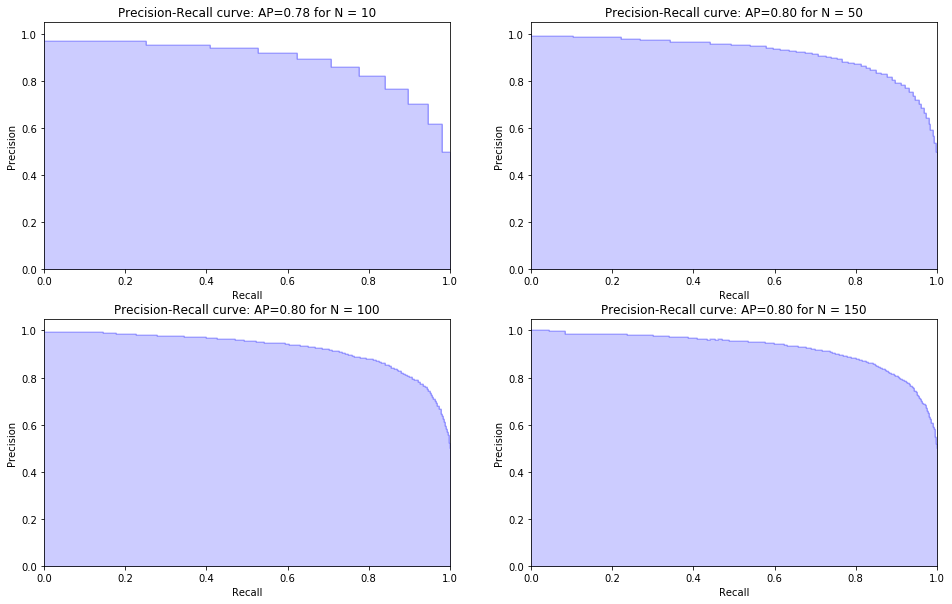

In [22]:
# COM NORMALIZACAO

estimators = [10, 50, 100, 150]
models = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for N = {}'.format(average_precision, n_est))
    print('\n--------------------------------------------------------------')
plt.show()

In [33]:
for m in models_norm:
    print(m)
    # Getting predictions
    y_predictions = m.predict_proba(X_test)
    y_score = m.predict(X_test)

    y_score = medfilt(y_score, 31)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))
    

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.0s finished


[0. 0. 0. ... 0. 0. 0.]
Average precision-recall score: 0.50
Precision: [0.5 0. ]
Recall: [1. 0.]
[[4642    0]
 [4642    0]]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    0.0s finished


[0. 0. 0. ... 0. 0. 0.]
Average precision-recall score: 0.50
Precision: [0.5 0. ]
Recall: [1. 0.]
[[4642    0]
 [4642    0]]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


[0. 0. 0. ... 0. 0. 0.]
Average precision-recall score: 0.50
Precision: [0.5 0. ]
Recall: [1. 0.]
[[4642    0]
 [4642    0]]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


[0. 0. 0. ... 0. 0. 0.]
Average precision-recall score: 0.50
Precision: [0.5 0. ]
Recall: [1. 0.]
[[4642    0]
 [4642    0]]


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished
C:\Users\v-pakova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   33.8s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.0s finished


Average precision-recall score: 0.81
Precision: [0.81273189 0.88469853]
Recall: [0.89659629 0.79340801]
[[4162  480]
 [ 959 3683]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   46.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


Average precision-recall score: 0.80
Precision: [0.78828328 0.89974293]
Recall: [0.91598449 0.75398535]
[[4252  390]
 [1142 3500]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   47.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=100, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


Average precision-recall score: 0.80
Precision: [0.78539741 0.89855447]
Recall: [0.91533822 0.74989229]
[[4249  393]
 [1161 3481]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   46.7s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 150 out of 150 | elapsed:    0.1s finished


Average precision-recall score: 0.80
Precision: [0.79100578 0.89732484]
Recall: [0.91318397 0.75872469]
[[4239  403]
 [1120 3522]]

--------------------------------------------------------------


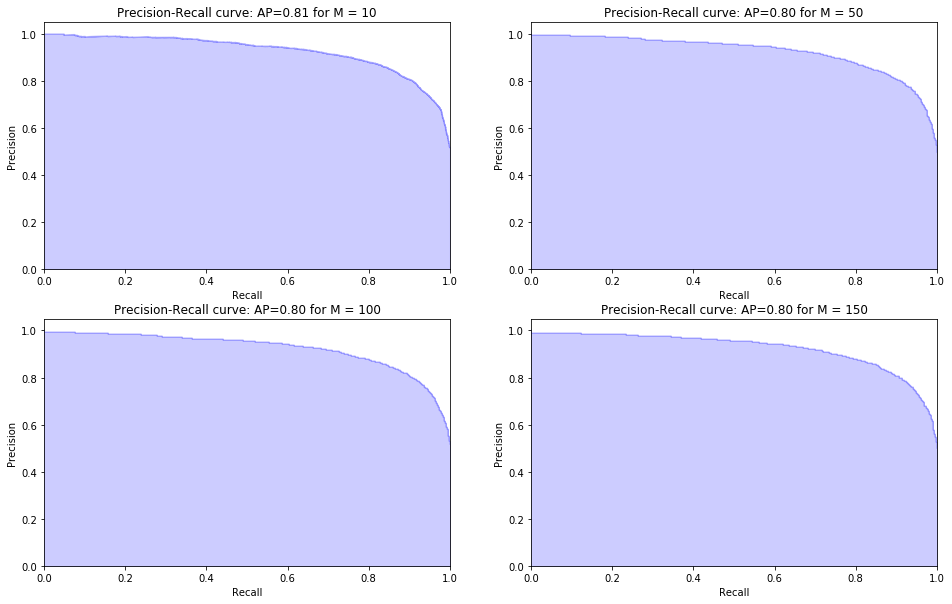

In [23]:
# COM NORMALIZACAO

depth = [10, 50, 100, 150]
models_2 = []
plt.figure(figsize=(16,10))
for i, m_dep in enumerate(depth):
    clf = RandomForestClassifier(n_estimators=150, verbose=1, n_jobs=-1, max_depth=m_dep)
    clf.fit(X_train, y_train)
    models_2.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for M = {}'.format(average_precision, depth[i]))
    print('\n--------------------------------------------------------------')
plt.show()

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  1.0min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


Average precision-recall score: 0.80
Precision: [0.78975791 0.89754727]
Recall: [0.91361482 0.75678587]
[[4241  401]
 [1129 3513]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.3min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:    0.2s finished


Average precision-recall score: 0.80
Precision: [0.78883945 0.90051414]
Recall: [0.91663076 0.75463162]
[[4255  387]
 [1139 3503]]

--------------------------------------------------------------


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=1,
            warm_start=False)


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.5s finished


Average precision-recall score: 0.81
Precision: [0.79376633 0.90091696]
Recall: [0.91619991 0.76195605]
[[4253  389]
 [1105 3537]]

--------------------------------------------------------------


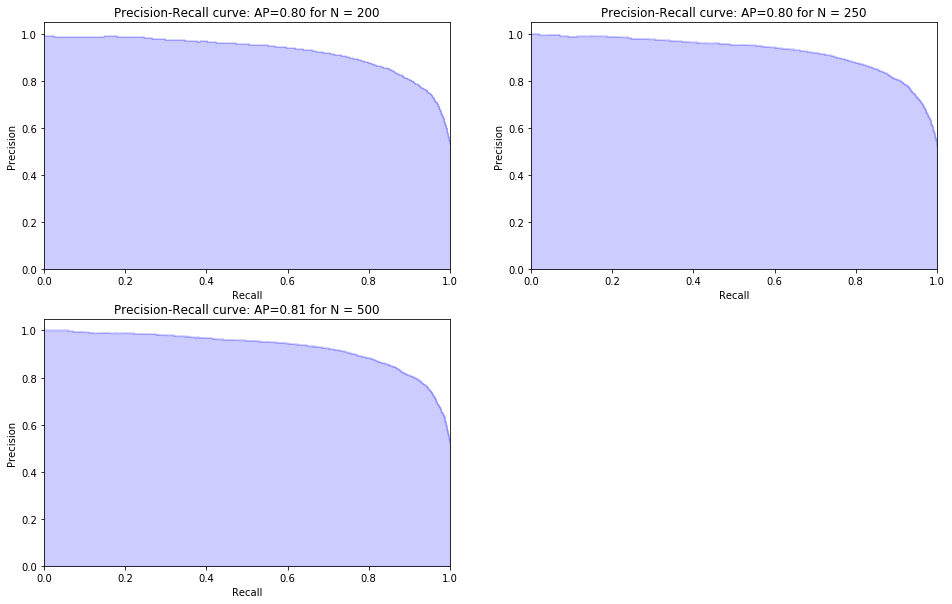

In [24]:
# COM NORMALIZACAO

estimators = [200, 250, 500]
models = []
plt.figure(figsize=(16,10))
for i, n_est in enumerate(estimators):
    clf = RandomForestClassifier(n_estimators=n_est, verbose=1, n_jobs=-1)
    clf.fit(X_train, y_train)
    models.append(clf)
    print(clf)

    # Getting predictions
    y_predictions = clf.predict_proba(X_test)
    y_score = clf.predict(X_test)

    # Calculating average precision
    average_precision = average_precision_score(y_test, y_score)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))

    # Getting precision and recall
    p_r_fs = precision_recall_fscore_support(y_test, y_score)
    print('Precision: {}'.format(p_r_fs[0]))
    print('Recall: {}'.format(p_r_fs[1]))

    print(confusion_matrix(y_test,y_score))

    # Plotting PR curve
    precision, recall, _ = precision_recall_curve(y_test, y_predictions[:, 1])

    plt.subplot(2,2,i+1)
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision-Recall curve: AP={:.2f} for N = {}'.format(average_precision, n_est))
    print('\n--------------------------------------------------------------')
plt.show()